# Milestone 4: Second Model

## Imports

In [73]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Loading

In [46]:
price_guide_tcg = pd.read_csv("price_guide_tcg_cleaned.csv", low_memory=False)
price_guide_tcg.dropna()
price_guide_tcg.describe()

,id,loose-price,graded-price,box-only-price,manual-only-price,bgs-10-price,condition-17-price,condition-18-price,sales-volume,hp
count,3.030000e+04,30132.000000,23242.000000,23345.000000,22502.000000,22504.000000,22653.000000,22507.000000,30300.000000,25631.000000
mean,1.815578e+06,9.113746,40.473400,50.029936,169.867231,260.751890,144.303368,101.864726,48.108482,96.110569
std,1.610918e+06,57.197150,203.630556,280.753070,1698.911993,2705.228337,641.144056,1019.301576,102.838685,52.140362
min,2.522800e+04,0.010000,0.140000,0.990000,0.980000,0.990000,1.000000,1.000000,1.000000,10.000000
25%,8.887088e+05,1.340000,12.060000,13.000000,34.910000,52.000000,44.000000,21.000000,5.000000,60.000000
50%,9.596655e+05,1.990000,16.065000,18.000000,42.720000,65.000000,50.000000,26.000000,12.000000,80.000000
75%,2.254008e+06,4.292500,29.807500,33.000000,90.045000,137.000000,99.990000,54.000000,38.000000,120.000000
max,7.747251e+06,4223.260000,17033.540000,27550.000000,221599.740000,332400.000000,42316.000000,132960.000000,1837.000000,340.000000


In [47]:
subset_df = price_guide_tcg[['rarity', 'types', 'generation', 'bgs-10-price', 'graded-price', 'hp', 'sales-volume']].copy()
print(subset_df.head())

         rarity          types generation  bgs-10-price  graded-price     hp  \
0      Uncommon            NaN      Sixth           NaN           NaN    NaN   
1      Uncommon            NaN      Sixth           NaN           NaN    NaN   
2      Uncommon            NaN      Sixth           NaN           NaN    NaN   
3      Uncommon            NaN      Sixth          58.0         15.11    NaN   
4  Rare Holo EX  ['Lightning']      Sixth          62.0         28.09  170.0   

   sales-volume  
0           5.0  
1           1.0  
2           1.0  
3           7.0  
4          81.0  


In [48]:
thresholds = {
    'types': 1000  ,        # Minimum count for 'types'
    'rarity': 1000  ,    # Minimum count for 'rarity'
    'generation':1500
}

In [49]:
for col, threshold in thresholds.items():
    counts = subset_df[col].value_counts()
    valid_categories = counts[counts >= threshold].index
    subset_df = subset_df[subset_df[col].isin(valid_categories)]

In [50]:
subset_df.shape

(18487, 7)

In [51]:
subset_df = subset_df.dropna()

In [52]:
subset_df.shape

(12759, 7)

In [53]:
subset_df.head()

,rarity,types,generation,bgs-10-price,graded-price,hp,sales-volume
9,Uncommon,['Grass'],Sixth,58.0,15.01,70.0,7.0
12,Common,['Psychic'],Sixth,36.0,9.28,60.0,29.0
13,Common,['Psychic'],Sixth,90.0,16.34,60.0,14.0
16,Uncommon,['Grass'],Sixth,58.0,23.00,120.0,24.0
17,Uncommon,['Grass'],Sixth,58.0,15.01,120.0,12.0


## Model 2

In [ ]:
subset_df['rarity_grouped'] = subset_df['rarity'].map(
    lambda x: 'Common/Uncommon' if x in ['Common', 'Uncommon'] else 'Rare/Rare Holo')

In [ ]:
subset_df['rarity_encoded'] = subset_df['rarity_grouped'].map(
    {'Common/Uncommon': 0, 'Rare/Rare Holo': 1})

top1 = subset_df['graded-price'].quantile(0.99)
subset_df = subset_df[subset_df['graded-price'] < top1]

(12759, 9)
(12631, 9)


In [56]:
encoder = OneHotEncoder()
types_encoded = encoder.fit_transform(subset_df[['types']]).toarray()
generation_encoded = encoder.fit_transform(subset_df[['generation']]).toarray()
numerical_features = ['bgs-10-price', 'graded-price', 'hp', 'sales-volume']

In [57]:
scaler = StandardScaler()
numerical_data = scaler.fit_transform(subset_df[numerical_features])

In [58]:
final_features = np.hstack([types_encoded, generation_encoded, numerical_data])
print(f"Final features shape: {final_features.shape}")

Final features shape: (12631, 21)


In [59]:
y = subset_df['rarity_encoded'].values
X_tensor = torch.tensor(final_features, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [60]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [61]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [62]:
input_size = final_features.shape[1]
model = NeuralNet(input_size)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
epochs = 1000
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate accuracy
        predictions = (outputs > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)

    epoch_loss = train_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    #print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


In [64]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions = (outputs > 0.5).float()
        y_true.extend(y_batch.numpy())
        y_pred.extend(predictions.numpy())

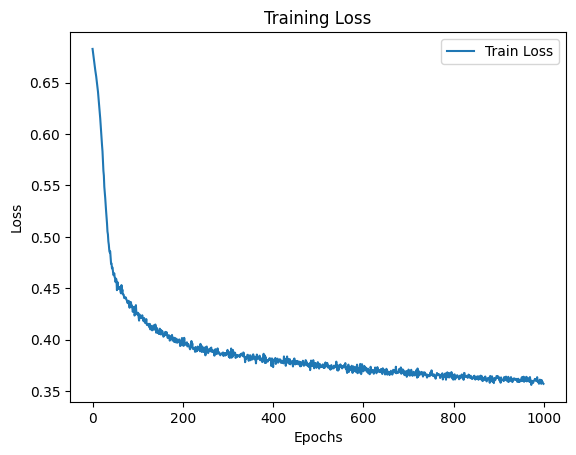

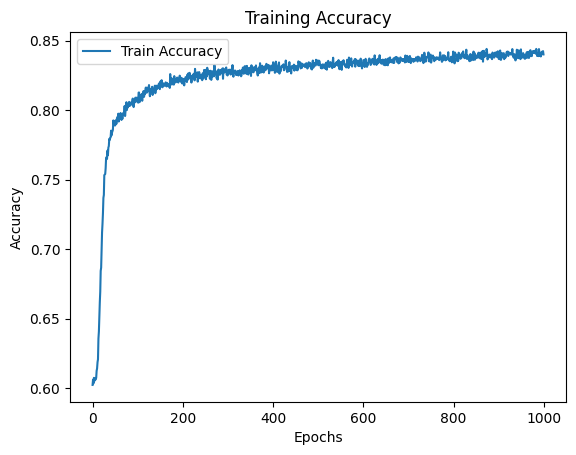

In [ ]:
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [ ]:
print(f"Final training accuracy: {train_accuracies[-1]}")

Final training accuracy: 0.840176450627757


## Model 2 -- Evaluation

In [ ]:
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

In [ ]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.8382585751978892
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      2267
         1.0       0.81      0.77      0.79      1523

    accuracy                           0.84      3790
   macro avg       0.83      0.83      0.83      3790
weighted avg       0.84      0.84      0.84      3790

Confusion Matrix:
 [[1997  270]
 [ 343 1180]]
